In [30]:
!pip install -U -q PyDrive
import numpy as np
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import drive as dr
from oauth2client.client import GoogleCredentials
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding,LSTM
from keras.layers.core import Dense,Dropout,Activation
from keras.utils import np_utils
import nltk, string, os, shutil
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

True

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
link='https://drive.google.com/open?id=1zfF92TEBUuJWXywGAQzLBU1fFAAvkjk3'
id = link.split('=')[1]
try:
  download_path = os.path.expanduser('~/data')
  if os.path.exists(download_path):
    shutil.rmtree(download_path)
  file_path = 'kindle_reviews.csv'
  os.makedirs(download_path)
  file_path = os.path.join(download_path, file_path)
  drive.CreateFile({'id': id}).GetContentFile(file_path)
except:
  dr.mount('/content/drive/')
  file_path = '/content/drive/My Drive/MCS F22/Sem 1/ALDA/Sentiment Analysis of Amazon Reviews/data/kindle_reviews.csv'

In [3]:
data = pd.read_csv(file_path)
data.head()

,Unnamed: 0,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0,B000F83SZQ,"[0, 0]",5,I enjoy vintage books and movies so I enjoyed ...,"05 5, 2014",A1F6404F1VG29J,Avidreader,Nice vintage story,1399248000
1,1,B000F83SZQ,"[2, 2]",4,This book is a reissue of an old one; the auth...,"01 6, 2014",AN0N05A9LIJEQ,critters,Different...,1388966400
2,2,B000F83SZQ,"[2, 2]",4,This was a fairly interesting read. It had ol...,"04 4, 2014",A795DMNCJILA6,dot,Oldie,1396569600
3,3,B000F83SZQ,"[1, 1]",5,I'd never read any of the Amy Brewster mysteri...,"02 19, 2014",A1FV0SX13TWVXQ,"Elaine H. Turley ""Montana Songbird""",I really liked it.,1392768000
4,4,B000F83SZQ,"[0, 1]",4,"If you like period pieces - clothing, lingo, y...","03 19, 2014",A3SPTOKDG7WBLN,Father Dowling Fan,Period Mystery,1395187200


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982619 entries, 0 to 982618
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Unnamed: 0      982619 non-null  int64 
 1   asin            982619 non-null  object
 2   helpful         982619 non-null  object
 3   overall         982619 non-null  int64 
 4   reviewText      982597 non-null  object
 5   reviewTime      982619 non-null  object
 6   reviewerID      982619 non-null  object
 7   reviewerName    978803 non-null  object
 8   summary         982618 non-null  object
 9   unixReviewTime  982619 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 75.0+ MB


## **Data Preprocessing**
### **Handling missing values**
We observe that columns like reviewText and Summary have a few missing values in a few rows. As the number of such rows is less, we simply drop the rows with missing values in these columns.

In [5]:
print(data.shape)
data.isna().sum()

(982619, 10)


Unnamed: 0           0
asin                 0
helpful              0
overall              0
reviewText          22
reviewTime           0
reviewerID           0
reviewerName      3816
summary              1
unixReviewTime       0
dtype: int64

In [6]:
data = data.dropna(subset = ['reviewText', 'summary'])
data.isna().sum()

Unnamed: 0           0
asin                 0
helpful              0
overall              0
reviewText           0
reviewTime           0
reviewerID           0
reviewerName      3816
summary              0
unixReviewTime       0
dtype: int64

### **Removing unwanted columns and random sampling**
Further, we observe that the reviewerName column is unwanted as we already have reviewerID. And Unnamed: 0 is unwanted as it is just the row number. So we can safely drop these columns. Also, as suggested in the project proposal, we would like to use only a subset of the original dataset for our project due to computational power restrictions. So let's drop all unwanted columns and randomly select only 10% rows of the dataset.

In [7]:
data = data.sample(frac=0.1, random_state=0).drop(['Unnamed: 0','reviewerName'], axis=1)
print('Rows, Cols: ', data.shape)
data.isna().sum()

Rows, Cols:  (98260, 8)


asin              0
helpful           0
overall           0
reviewText        0
reviewTime        0
reviewerID        0
summary           0
unixReviewTime    0
dtype: int64

In [8]:
stop_words = set(stopwords.words('english')) 
def tokenize(text):
    tokenized = word_tokenize(text.lower())
    no_punc = []
    for word in tokenized:
        if word not in stop_words:
          word = [char for char in word if char not in string.punctuation]
          ps=PorterStemmer()
          line = "".join(ps.stem(char) for char in word)
          no_punc.append(line)
    tokens = lemmatize(no_punc)
    return tokens

def lemmatize(tokens):
    lmtzr = WordNetLemmatizer()
    lemma = [lmtzr.lemmatize(t) for t in tokens]
    return ' '.join(lemma)

data['cleanedReviews'] = data['reviewText'].apply(lambda x: tokenize(x))

In [9]:
data.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,summary,unixReviewTime,cleanedReviews
635827,B00EXCZXYE,"[0, 0]",4,I received a free ARC of this book to reviewTh...,"09 10, 2013",A1O6FJ7J9RMDZI,"After reading this one, I can't wait to read t...",1378771200,received free arc book reviewthe real strength...
405979,B00B0WFHKU,"[0, 0]",4,A little short but a very sweet love story. I ...,"04 13, 2014",A5EG41230ZPJ9,sweet story,1397347200,little short sweet love story loved man domin...
895747,B00JNAPM9M,"[2, 2]",5,Like many people I was very surprised on the i...,"05 8, 2014",A1X77VOIB1LYC7,If only I learned this growing up&#8230;,1399507200,like many people surprised information book s...
283696,B008Z5JTKO,"[0, 2]",4,Because I like to read the Historial and weste...,"02 18, 2013",A2QU0L4Q1KNKJ0,Well writen and I really enjoy that type of book.,1361145600,like read historial western style book cute ...
172574,B0073HF7YW,"[0, 0]",5,"This book is refreshingly different, yet surpr...","05 2, 2012",A2SBSCTVGYTBIX,Amazing book for ALL ages,1335916800,book refreshingly different yet surprisingly ...


## **Data Modeling**
Let's visualize the 'overall' column which has the ratings for each review.

Unique Ratings:  [1, 2, 3, 4, 5]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f42cee6be80>]],
      dtype=object)

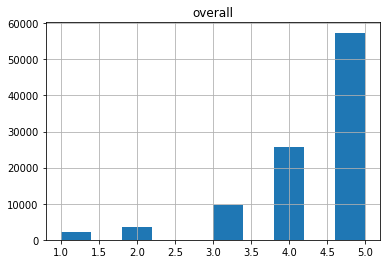

In [10]:
print('Unique Ratings: ', sorted(data['overall'].unique()))
data.hist('overall')

We observe that there are 5 ratings 1 being the worst, 3 being neutral and 5 being the best rating. Now, let's assign a Sentiment Score to each of the reviews based on their ratings such that ratings 1 and 2 get a low sentiment score of 0 and ratings 4 and 5 get a higher sentiment score of 1. All rows will neutral rating 3 will be removed.

Insert `Sentiment_Score` column for **Sentiment modeling**:<br/>
Remove Neutral Reviews: 3 stars<br/>
Negative reviews:      1-2 Stars  = 0<br/>
Positive reviews:      4-5 Stars  = 1

In [11]:
data = data[data['overall'] != 3]
data['Sentiment_Score'] = np.where(data['overall'] > 3, 1, 0)
data.head()

<ipython-input-11-79f356ada4ce>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Sentiment_Score'] = np.where(data['overall'] > 3, 1, 0)


,asin,helpful,overall,reviewText,reviewTime,reviewerID,summary,unixReviewTime,cleanedReviews,Sentiment_Score
635827,B00EXCZXYE,"[0, 0]",4,I received a free ARC of this book to reviewTh...,"09 10, 2013",A1O6FJ7J9RMDZI,"After reading this one, I can't wait to read t...",1378771200,received free arc book reviewthe real strength...,1
405979,B00B0WFHKU,"[0, 0]",4,A little short but a very sweet love story. I ...,"04 13, 2014",A5EG41230ZPJ9,sweet story,1397347200,little short sweet love story loved man domin...,1
895747,B00JNAPM9M,"[2, 2]",5,Like many people I was very surprised on the i...,"05 8, 2014",A1X77VOIB1LYC7,If only I learned this growing up&#8230;,1399507200,like many people surprised information book s...,1
283696,B008Z5JTKO,"[0, 2]",4,Because I like to read the Historial and weste...,"02 18, 2013",A2QU0L4Q1KNKJ0,Well writen and I really enjoy that type of book.,1361145600,like read historial western style book cute ...,1
172574,B0073HF7YW,"[0, 0]",5,"This book is refreshingly different, yet surpr...","05 2, 2012",A2SBSCTVGYTBIX,Amazing book for ALL ages,1335916800,book refreshingly different yet surprisingly ...,1


### **Generating WordCloud**
Now, we separate the reviews based on the Sentiment_Score and create word clouds for positive and negative reviews

In [12]:
pos = data.loc[data['Sentiment_Score'] == 1]
neg = data.loc[data['Sentiment_Score'] == 0]

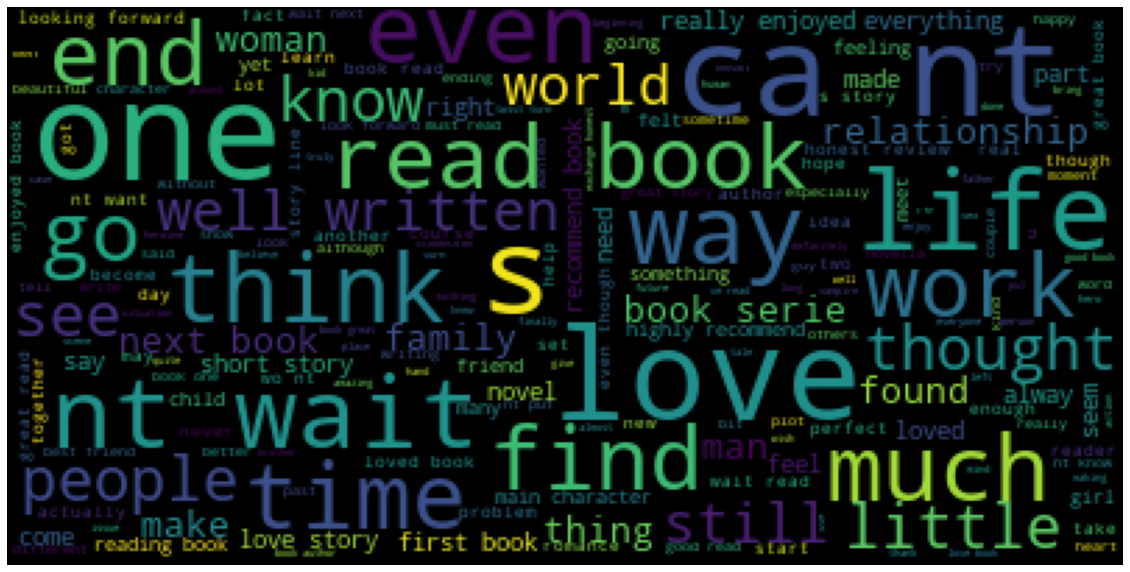

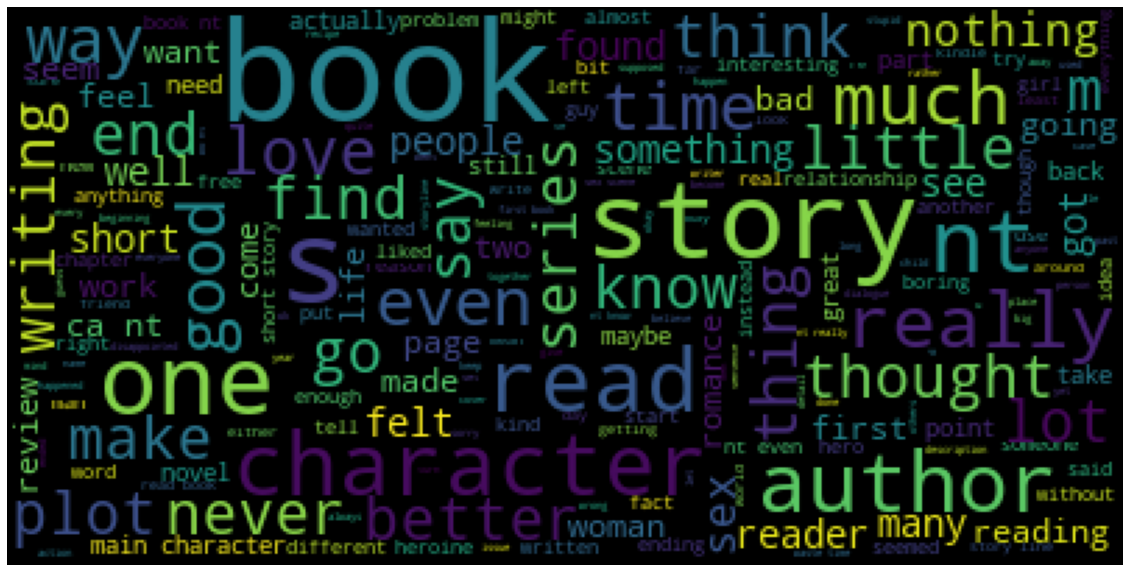

In [13]:
def plot_word_cloud(data):
  word_corpus = ''
  word_corpus += ' '.join(data['cleanedReviews'].values)
  wordcloud = WordCloud(max_font_size=50).generate(word_corpus)
  plt.figure(figsize=(20,20))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()

plot_word_cloud(pos)
plot_word_cloud(neg)

## **Data Transformation**
### **CountVectorizer**
We cannot directly feed our cleaned reviews to any machine learning model because machine learning models take numbers as input while our reviews are in string format. So, we use CountVectorizer to convert the cleaned reviews into vectors of frequency count of each word that occurs in the entire text.

In [14]:
countVect = CountVectorizer()
data_countVect = countVect.fit_transform(data['cleanedReviews'])
print("Number of features : %d \n" %len(countVect.get_feature_names_out()))
print("Visualize first few feature names : \n", countVect.get_feature_names_out()[::1000])

Number of features : 134977 

Visualize first few feature names : 
 ['00' '2013amazon' '4yearmarriage' 'abruptness' 'adorable' 'agreeyou'
 'ally' 'andithey' 'anythingwonderful' 'arounddisclosure' 'attractionwill'
 'aye' 'barrabas' 'beginhe' 'betterin' 'blissmy' 'bookisabelle' 'boyers'
 'brooklynthis' 'byproduct' 'carley' 'chabella' 'cheatedon' 'cim' 'cod3'
 'completed' 'contemporaryshort' 'counteracts' 'crom' 'damn' 'deathsee'
 'denigrates' 'devising' 'disappointdax' 'does8' 'downsorry' 'durfey'
 'egi' 'empirical' 'enoughdemelza' 'estoy' 'executive' 'fabulousthis'
 'fash' 'fictioninteresting' 'flexible' 'formeractive' 'froh' 'ganache'
 'giancanti' 'goodbyecarl' 'gregit' 'hades' 'hardshort' 'heartpumpingly'
 'hermichelle' 'himlow' 'hooper' 'hunkmona' 'immediatelybeing' 'infinity'
 'interactivity' 'isbn' 'jabrilwell' 'jobvernetta' 'kastan'
 'kindlesummary' 'lackingi' 'leahy' 'lifecopy' 'littlesister' 'losetrack'
 'lusher' 'malplay' 'maskala' 'meatballstender' 'messwow' 'mircles'
 'moodif

### **Handling Imbalanced Data**
We can see below that the data is highly imbalanced as it contains very few rows with 0 Sentiment Score. To balance this, we use `RandomOverSampler`

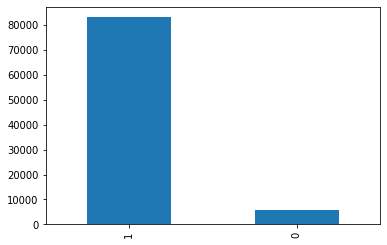

In [15]:
data['Sentiment_Score'].value_counts().plot(kind = 'bar')

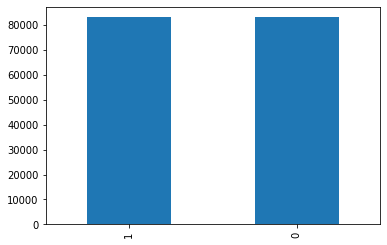

In [16]:
ROS = RandomOverSampler(random_state=777)
X_ROS, y_ROS = ROS.fit_resample(data_countVect, data['Sentiment_Score'])
y_ROS.value_counts().plot(kind = 'bar')

### **Train Test Split**
We use 90% of the data for training and 10% for testing.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_ROS, y_ROS, test_size=0.1, random_state=0)
print("X_train shape: {}".format(X_train.shape), end='\n')
print("y_train shape: {}".format(y_train.shape), end='\n\n')
print("X_test shape: {}".format(X_test.shape), end='\n')
print("y_test shape: {}".format(y_test.shape), end='\n\n')

X_train shape: (149491, 134977)
y_train shape: (149491,)

X_test shape: (16611, 134977)
y_test shape: (16611,)



# **Model Training & Prediction**

## **Multinomial Naive Bayes**

In [18]:
mnb = MultinomialNB()
history = mnb.fit(X_train, y_train)

Training set score: 0.942
Test set score: 0.940
Accuracy on validation set: 0.9399
AUC score : 0.9397

Classification report : 
               precision    recall  f1-score   support

           0       0.92      0.96      0.94      8373
           1       0.96      0.92      0.94      8238

    accuracy                           0.94     16611
   macro avg       0.94      0.94      0.94     16611
weighted avg       0.94      0.94      0.94     16611



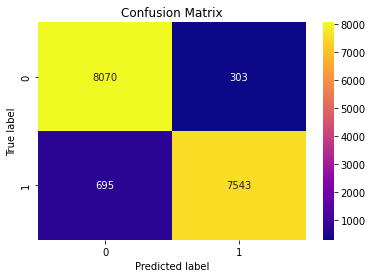

In [19]:
y_pred = mnb.predict(X_test)
print("Training set score: {:.3f}".format(mnb.score(X_train, y_train)))
print("Test set score: {:.3f}".format(mnb.score(X_test, y_test)))
print ("Accuracy on validation set: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("AUC score : {:.4f}".format(roc_auc_score(y_test, y_pred)))
print("\nClassification report : \n", classification_report(y_test, y_pred))
cn = confusion_matrix(y_test, y_pred)
sns.heatmap(cn,cmap='plasma',annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### **Hyperparameter Optimization using GridSearchCV**
Now, we try to improve the accuracy of 94% obtained above using GridSearchCV by tuning the `alpha` hyperparameter of the `MultinomialNB` classifier.

Fitting 5 folds for each of 7 candidates, totalling 35 fits
The Best Model Achieved for Multinomial Naive Bayes with Accuracy 0.939919330564084 and the best parameters are {'clf__alpha': 0.0001}
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      8373
           1       0.97      0.94      0.95      8238

    accuracy                           0.95     16611
   macro avg       0.95      0.95      0.95     16611
weighted avg       0.95      0.95      0.95     16611



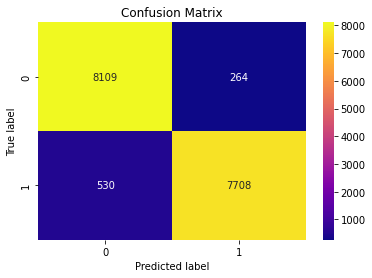

In [20]:
pipeline = Pipeline([(('clf', MultinomialNB()))])
parameters = {'clf__alpha': [0.0001, 0.001, 0.1, 1, 10, 100,1000]}
gs = GridSearchCV(pipeline, parameters, verbose=2, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print('The Best Model Achieved for Multinomial Naive Bayes with Accuracy {} and the best parameters are {}'.format(accuracy_score(y_test,y_pred),gs.best_params_))
y_pred = gs.predict(X_test)
print(classification_report(y_test, y_pred))
cn = confusion_matrix(y_test, y_pred)
sns.heatmap(cn,cmap='plasma',annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### **Plots**

#### ROC Curve

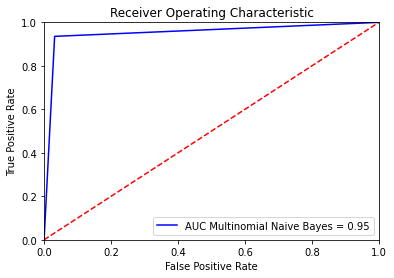

In [21]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC Multinomial Naive Bayes = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### **Bar Plots**

Text(0.5, 1.0, 'Predictions')

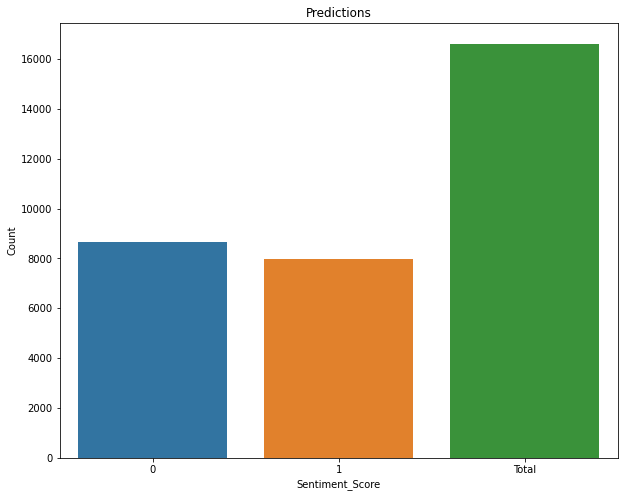

In [22]:
bar = pd.DataFrame({'Sentiment_Score':['0','1','Total']})
bar['Count'] = [len(np.where(y_pred == 0)[0]), len(np.where(y_pred == 1)[0]), len(y_pred)]
plt.figure(figsize= (10,8))
sns.barplot(x = "Sentiment_Score", y = "Count", data = bar)
plt.title("Predictions")

### **Stratified K-fold Cross Validation**
In order to make our model more generalized, we make use of Stratified K-fold cross validation. We use the `alpha` value which we got from GridSearchCV for better results.

The Stratified K-fold Cross Validation Accuracy for MNB: 0.9497537700243681
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     83051
           1       0.97      0.93      0.95     83051

    accuracy                           0.95    166102
   macro avg       0.95      0.95      0.95    166102
weighted avg       0.95      0.95      0.95    166102



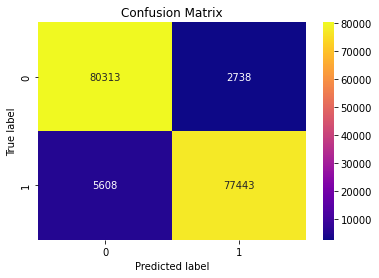

In [23]:
mnb_accuracies = []
y_tests = np.empty([0], dtype=int)
y_preds = np.empty([0], dtype=int)
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
for train_index, test_index in skf.split(X_ROS, y_ROS):
  X_train = X_ROS[train_index]
  y_train = y_ROS[train_index]
  X_test = X_ROS[test_index]
  y_test = y_ROS[test_index]
  mnb = MultinomialNB(alpha = 0.0001)
  history = mnb.fit(X_train, y_train)
  y_pred = mnb.predict(X_test)
  mnb_accuracies.append(accuracy_score(y_test,y_pred))
  y_tests = np.append(y_tests, y_test)
  y_preds = np.append(y_preds, y_pred)
print('The Stratified K-fold Cross Validation Accuracy for MNB:',sum(mnb_accuracies)/len(mnb_accuracies))
print(classification_report(y_tests, y_preds))
cn = confusion_matrix(y_tests, y_preds)
sns.heatmap(cn,cmap='plasma',annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Decision Tree**

In [ ]:
decision_tree = DecisionTreeClassifier()
  
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)
y_pred_train = decision_tree.predict(X_train)

print ("Accuracy on validation set: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("AUC score : {:.4f}".format(roc_auc_score(y_test, y_pred)))
print("\nClassification report : \n", classification_report(y_test, y_pred))
cn = confusion_matrix(y_test, y_pred)
sns.heatmap(cn,cmap='plasma',annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print("Maximum depth of the decision tree: {}".format(decision_tree.tree_.max_depth))
print("Number of leaves in the decision tree: {}".format(decision_tree.tree_.n_leaves))

### **Hyperparameter Optimization using GridSearchCV**
Now, we try to improve the accuracy of 96.3% obtained above using GridSearchCV by tuning the `criterion` and `min_samples_split` hyperparameters of the `DecisionTree` classifier.

In [ ]:
param_dict = {
    "criterion":['gini', 'entropy'],
    "min_samples_split":[2,3,4,5,10,15,20]
}
grid = GridSearchCV(decision_tree,
                    param_grid=param_dict,
                    verbose=1,
                    n_jobs=-1)
grid.fit(X_train, y_train)

print("Best parameters: {}".format(grid.best_params_))
print("Score with best estimator: {}".format(grid.best_score_))

y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))
cn = confusion_matrix(y_test, y_pred)
sns.heatmap(cn,cmap='plasma',annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### **Plots**

#### ROC Plot

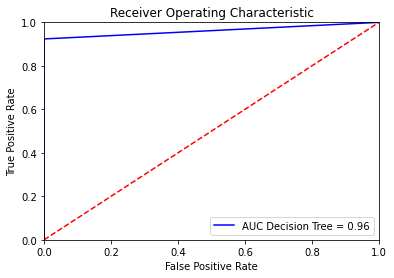

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC Decision Tree = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Bar Plot

Text(0.5, 1.0, 'Predictions')

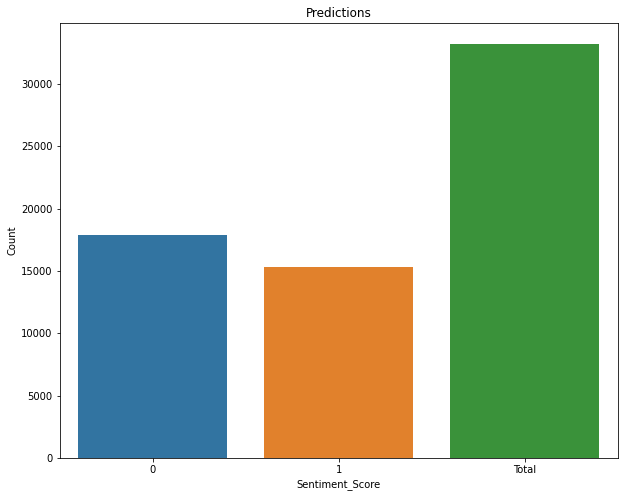

In [ ]:
bar = pd.DataFrame({'Sentiment_Score':['0','1','Total']})
bar['Count'] = [len(np.where(y_pred == 0)[0]), len(np.where(y_pred == 1)[0]), len(y_pred)]
plt.figure(figsize= (10,8))
sns.barplot(x = "Sentiment_Score", y = "Count", data = bar)
plt.title("Predictions")

### **Stratified K-fold Cross Validation**
In order to make our model more generalized, we make use of Stratified K-fold cross validation. We use the `criterion` and `min_split_samples` value which we got from GridSearchCV for better results.

In [ ]:
decision_tree_accuracies = []
y_tests = np.empty([0], dtype=int)
y_preds = np.empty([0], dtype=int)
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
for train_index, test_index in skf.split(X_ROS, y_ROS):
  X_train = X_ROS[train_index]
  y_train = y_ROS[train_index]
  X_test = X_ROS[test_index]
  y_test = y_ROS[test_index]
  decision_tree = DecisionTreeClassifier(criterion="entropy")
  history = decision_tree.fit(X_train, y_train)
  y_pred = decision_tree.predict(X_test)
  decision_tree_accuracies.append(accuracy_score(y_test,y_pred))
  y_tests = np.append(y_tests, y_test)
  y_preds = np.append(y_preds, y_pred)
print('The Stratified K-fold Cross Validation Accuracy for Decision Tree:',sum(decision_tree_accuracies)/len(decision_tree_accuracies))
print(classification_report(y_tests, y_preds))
cn = confusion_matrix(y_tests, y_preds)
sns.heatmap(cn,cmap='plasma',annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Logistic Regression**

Training set score: 0.988
Test set score: 0.973
Accuracy on validation set: 0.973
AUC score : 0.9727

Classification report : 
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     16610
           1       0.99      0.95      0.97     16610

    accuracy                           0.97     33220
   macro avg       0.97      0.97      0.97     33220
weighted avg       0.97      0.97      0.97     33220



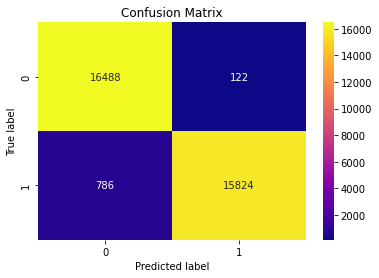

In [24]:
lr = LogisticRegression(solver = 'liblinear', random_state = 42, max_iter=1000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print("Training set score: {:.3f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.3f}".format(lr.score(X_test, y_test)))
print("Accuracy on validation set: {:.3f}".format(round(accuracy_score(y_test,y_pred),3)))
print("AUC score : {:.4f}".format(roc_auc_score(y_test, y_pred)))
print("\nClassification report : \n", classification_report(y_test, y_pred))
cn = confusion_matrix(y_test, y_pred)
sns.heatmap(cn,cmap='plasma',annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### **Hyperparameter Optimization using GridSearchCV**
Now, we try to improve the accuracy of 97.5% obtained above using GridSearchCV by tuning the `clf__penalty` and `clf__C` hyperparameters of the `LogisticRegression` classifier.

The Best Model Achieved for Logistic Regression with Accuracy 0.9726670680313064 and the best parameters are {'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     16610
           1       0.99      0.95      0.97     16610

    accuracy                           0.97     33220
   macro avg       0.97      0.97      0.97     33220
weighted avg       0.97      0.97      0.97     33220



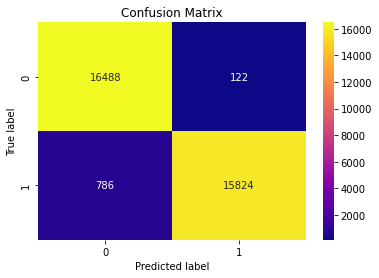

In [25]:
pipeline = Pipeline([(('clf', LogisticRegression(random_state=42)))])
parameters = {'clf__penalty': ['l1', 'l2'],
        'clf__C': [1.0, 0.5],
        'clf__solver': ['liblinear']}
gs = GridSearchCV(pipeline, parameters)
gs = gs.fit(X_train, y_train)
print('The Best Model Achieved for Logistic Regression with Accuracy {} and the best parameters are {}'.format(accuracy_score(y_test,y_pred),gs.best_params_))
y_pred = gs.predict(X_test)
print(classification_report(y_test, y_pred))
cn = confusion_matrix(y_test, y_pred)
sns.heatmap(cn,cmap='plasma',annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

###**Plots**

####ROC Curve

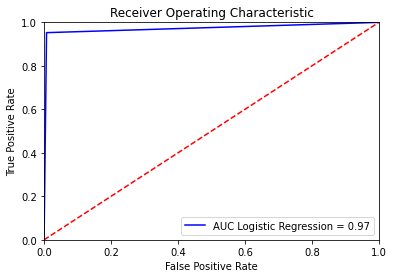

In [26]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC Logistic Regression = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

####Bar plot

Text(0.5, 1.0, 'Predictions')

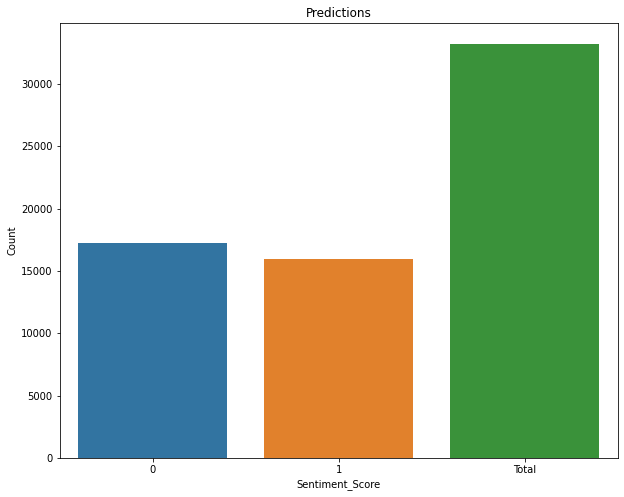

In [27]:
bar = pd.DataFrame({'Sentiment_Score':['0','1','Total']})
bar['Count'] = [len(np.where(y_pred == 0)[0]), len(np.where(y_pred == 1)[0]), len(y_pred)]
plt.figure(figsize= (10,8))
sns.barplot(x = "Sentiment_Score", y = "Count", data = bar)
plt.title("Predictions")

### **Stratified K-fold Cross Validation**
In order to make our model more generalized, we make use of Stratified K-fold cross validation.

The Stratified K-fold Cross Validation Accuracy for Logistic Regression: 0.9729323006974202
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     83051
           1       0.99      0.95      0.97     83051

    accuracy                           0.97    166102
   macro avg       0.97      0.97      0.97    166102
weighted avg       0.97      0.97      0.97    166102



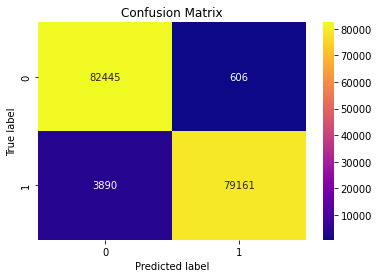

In [28]:
from sklearn.model_selection import StratifiedKFold
lr_accuracies = []
y_tests = np.empty([0], dtype=int)
y_preds = np.empty([0], dtype=int)
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
for train_index, test_index in skf.split(X_ROS, y_ROS):
  X_train = X_ROS[train_index]
  y_train = y_ROS[train_index]
  X_test = X_ROS[test_index]
  y_test = y_ROS[test_index]
  lr = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42, C=1.0, penalty='l2')
  history = lr.fit(X_train, y_train)
  y_pred = lr.predict(X_test)
  lr_accuracies.append(accuracy_score(y_test,y_pred))
  y_tests = np.append(y_tests, y_test)
  y_preds = np.append(y_preds, y_pred)
print('The Stratified K-fold Cross Validation Accuracy for Logistic Regression:',sum(lr_accuracies)/len(lr_accuracies))
print(classification_report(y_tests, y_preds))
cn = confusion_matrix(y_tests, y_preds)
sns.heatmap(cn,cmap='plasma',annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **K-Nearest Neighbours**

1 [0.9708237559570698]
3 [0.9708237559570698, 0.9521455460700936]
5 [0.9708237559570698, 0.9521455460700936, 0.8880360224424404]
7 [0.9708237559570698, 0.9521455460700936, 0.8880360224424404, 0.8700501552326108]
9 [0.9708237559570698, 0.9521455460700936, 0.8880360224424404, 0.8700501552326108, 0.8531855766995753]

The optimal number of neighbors is 1.
the misclassification error for each k value is :  [0.029 0.048 0.112 0.13  0.147]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     16610
           1       1.00      0.95      0.98     16610

    accuracy                           0.98     33220
   macro avg       0.98      0.98      0.98     33220
weighted avg       0.98      0.98      0.98     33220



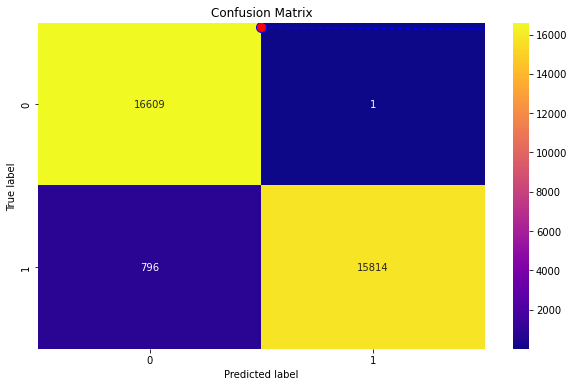

In [31]:
def optimal_K(x_train, y_train, lst): 
   neighbors = list(filter(lambda x: x % 2 != 0, lst))
   cv_scores = []

   # perform 5-fold cross validation
   for k in neighbors:
     knn = KNeighborsClassifier(n_neighbors=k)
     scores = cross_val_score(knn, x_train, y_train, cv = 5, scoring='accuracy')
     cv_scores.append(scores.mean())
     print(k, cv_scores)
  
   MSE = [1 - x for x in cv_scores]

   # determining best k
   optimal_k = neighbors[MSE.index(min(MSE))]
   print('\nThe optimal number of neighbors is %d.' % optimal_k)

   plt.figure(figsize=(10,6))
   plt.plot(list(filter(lambda x: x % 2 != 0, lst)),MSE,color='blue', linestyle='dashed', marker='o',
            markerfacecolor='red', markersize=10)
   plt.title('Error Rate vs. K Value')
   plt.xlabel('K')
   plt.ylabel('Error Rate')
   print("the misclassification error for each k value is : ", np.round(MSE,3))
   return optimal_k

from sklearn.preprocessing import StandardScaler

final_bow_np = StandardScaler(with_mean=False).fit_transform(data_countVect)
myList = list(range(0, 10))
optimal_k = optimal_K(X_train, y_train, myList)

knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

print(classification_report(y_test ,pred))
cn = confusion_matrix(y_test, pred)
sns.heatmap(cn,cmap='plasma',annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

###**Plots**

### **Hyperparameter Optimization using GridSearchCV**
Now, we try to improve the accuracy of 98% obtained above using GridSearchCV by tuning the `n_neighbours` hyperparameter of the `KNeighborsClassifier` classifier.

In [32]:
grid_params = { 'n_neighbors' : [1,3,5,7,9]}

gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv=5, n_jobs = -1)

g_res = gs.fit(X_train, y_train)
print(g_res.best_score_)
print(g_res.best_params_)
knn = KNeighborsClassifier(n_neighbors = g_res.best_params_['n_neighbors'])
knn.fit(X_train, y_train)
y_hat = knn.predict(X_train)
y_knn = knn.predict(X_test)
print(classification_report(y_test ,y_knn))
cn = confusion_matrix(y_test, pred)
sns.heatmap(cn,cmap='plasma',annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

####ROC Curve

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, y_knn)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC K Nearest Neighbors = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

####Bar Plot

Text(0.5, 1.0, 'Predictions')

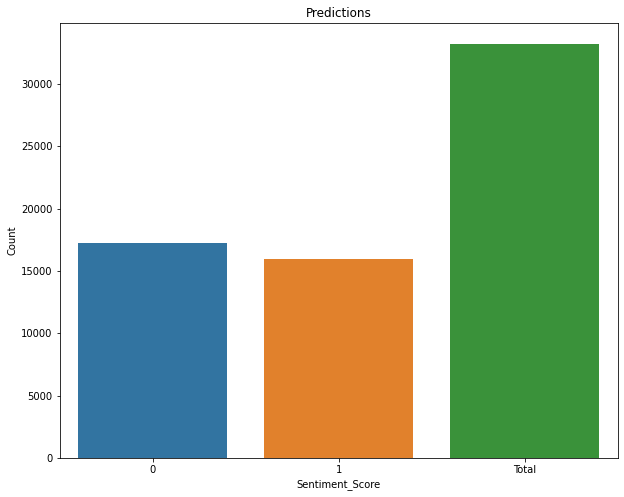

In [33]:
bar = pd.DataFrame({'Sentiment_Score':['0','1','Total']})
bar['Count'] = [len(np.where(y_pred == 0)[0]), len(np.where(y_pred == 1)[0]), len(y_pred)]
plt.figure(figsize= (10,8))
sns.barplot(x = "Sentiment_Score", y = "Count", data = bar)
plt.title("Predictions")

### **Stratified K-fold Cross Validation**
In order to make our model more generalized, we make use of Stratified K-fold cross validation.

In [ ]:
from sklearn.model_selection import StratifiedKFold
knn_accuracies = []
y_tests = np.empty([0], dtype=int)
y_preds = np.empty([0], dtype=int)
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
for train_index, test_index in skf.split(X_ROS, y_ROS):
  X_train = X_ROS[train_index]
  y_train = y_ROS[train_index]
  X_test = X_ROS[test_index]
  y_test = y_ROS[test_index]
  knn = KNeighborsClassifier(n_neighbors = 1)
  history = knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  knn_accuracies.append(accuracy_score(y_test,y_pred))
  y_tests = np.append(y_tests, y_test)
  y_preds = np.append(y_preds, y_pred)
print('The Stratified K-fold Cross Validation Accuracy for K Nearest Neighbors:',sum(knn_accuracies)/len(knn_accuracies))
print(classification_report(y_tests, y_preds))
cn = confusion_matrix(y_tests, y_preds)
sns.heatmap(cn,cmap='plasma',annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Long Short Term Memory (LSTM)**

In [34]:
X_train, X_test, y_train, y_test = train_test_split(data['reviewText'], data['Sentiment_Score'], test_size=0.1, random_state=0)

# Now, we Vectorize X_train and X_test to 2D tensor and only consider top 20000 words in the corpse
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=100)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=100)
y_train_seq = np_utils.to_categorical(y_train, 2)
y_test_seq = np_utils.to_categorical(y_test, 2)

def build_LSTM():
  lstm = Sequential()
  lstm.add(Embedding(20000, 128))
  lstm.add(Dropout(0.2))
  lstm.add(LSTM(128))
  lstm.add(Dropout(0.2)) 
  lstm.add(Dense(2))
  lstm.add(Activation('softmax'))
  lstm.summary()

  lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return lstm

lstm = build_LSTM()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2560000   
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
 activation (Activation)     (None, 2)                 0         
                                                                 
Total params: 2,691,842
Trainable params: 2,691,842
Non-

In [35]:
lstm.fit(X_train_seq, y_train_seq, batch_size=32, epochs=3, verbose=1)
score = lstm.evaluate(X_test_seq, y_test_seq, batch_size=32)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

Epoch 1/3
2496/2496 [==============================] - 565s 225ms/step - loss: 0.1329 - accuracy: 0.9544
Epoch 2/3
2496/2496 [==============================] - 553s 221ms/step - loss: 0.0718 - accuracy: 0.9740
Epoch 3/3
278/278 [==============================] - 18s 64ms/step - loss: 0.1038 - accuracy: 0.9661
Test loss : 0.1038
Test accuracy : 0.9661


### **Stratified K-fold Cross Validation**
In order to make our model more generalized, we make use of Stratified K-fold cross validation. We use the `alpha` value which we got from GridSearchCV for better results.

In [ ]:
lstm_accuracies = []
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in skf.split(data['reviewText'].values, data['Sentiment_Score'].values):
  X_train = data['reviewText'].values[train_index]
  y_train = data['Sentiment_Score'].values[train_index]
  X_test = data['reviewText'].values[test_index]
  y_test = data['Sentiment_Score'].values[test_index]
  X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=100)
  X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=100)
  y_train_seq = np_utils.to_categorical(y_train, 2)
  y_test_seq = np_utils.to_categorical(y_test, 2)
  lstm = build_LSTM()
  lstm.fit(X_train_seq, y_train_seq, batch_size=32, epochs=3, verbose=1)
  score = lstm.evaluate(X_test_seq, y_test_seq, batch_size=32)
  lstm_accuracies.append(score[1])
print('The Stratified K-fold Cross Validation Accuracy for LSTM:',sum(lstm_accuracies)/len(lstm_accuracies))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         2560000   
                                                                 
 dropout_2 (Dropout)         (None, None, 128)         0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
 activation_1 (Activation)   (None, 2)                 0         
                                                                 
Total params: 2,691,842
Trainable params: 2,691,842
No